In [5]:
import os

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from util.TrainRoutine import AutoEncTrainRoutine
from util.Evaluator import Evaluator
from util.aedpmerf import AEDPMERF

We want to use the DPMERF algorithm on time series data. But we will not work on time series directly, because it does not model the temporal relation correctly. Instead we will train an AE first and use DPMERF on the encoding space, where there is no notion of time and ordering.

In [6]:
emb_dim = 32
aedpmerf = AEDPMERF(is_priv=True)

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


In [7]:
model_name = f"lstmae_180_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    aedpmerf.load_ae(model_name)
else:
    model, history = aedpmerf.train_ae()
    plt.plot(history["train"])
    plt.plot(history["val"])
    aedpmerf.save_ae(model_name)

loading AE model from models/lstmae_180_embed32.pth


In [9]:
enc_df = aedpmerf.encode_train_data(train_ds_path="data/normal_train_180.csv", fname=f"data/normal_training_encoded_embed{emb_dim}.csv")
aedpmerf.train_gen(data=enc_df, mini_batch_size=0.1, lr=1e-2)
n_gen_samples = enc_df.shape[0]
gen_data = aedpmerf.generate(n_gen_samples, fname=f"enc_gen_priv_embed{emb_dim}.csv")

saving encoded training data in data/normal_training_encoded_embed32.csv
minibatch:  6334
total number of datapoints in the training data is 63326
random freq (1000, 32)
adding DP noise
Starting Training
epoch # and running loss are  [0, 4.312779873609543]
epoch # and running loss are  [100, 0.003567905747331679]
epoch # and running loss are  [200, 0.0030025025625946]
epoch # and running loss are  [300, 0.0018571962864371017]
epoch # and running loss are  [400, 0.0018872524378821254]
epoch # and running loss are  [500, 0.0013900644407840446]
epoch # and running loss are  [600, 0.0013146834826329723]
epoch # and running loss are  [700, 0.0014135242236079648]
epoch # and running loss are  [800, 0.001405844886903651]
epoch # and running loss are  [900, 0.0029241535521578044]
epoch # and running loss are  [1000, 0.0012865796379628591]
epoch # and running loss are  [1100, 0.0016403466579504311]
epoch # and running loss are  [1200, 0.001567334431456402]
epoch # and running loss are  [1300, 0

In [13]:
pd.DataFrame(gen_data).to_csv(f"data/generated/normal_train_180_embed{emb_dim}_priv_merf.csv")

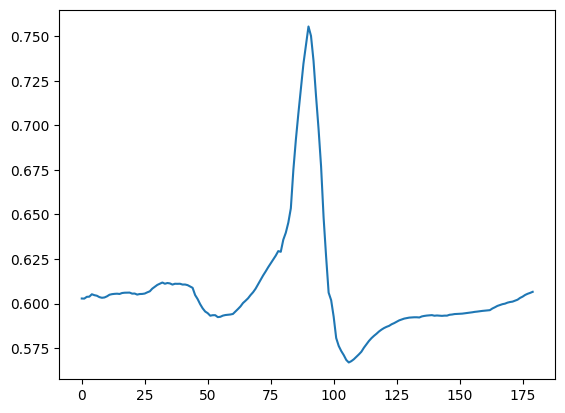

In [10]:
plt.plot(gen_data[30])

In [11]:
ae_gen = AutoEncTrainRoutine()

------------------------------
Initialising Autoencoder with:
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 64, batch_first=True)
    (rnn2): LSTM(64, 32, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(32, 32, batch_first=True)
    (rnn2): LSTM(32, 64, batch_first=True)
    (output_layer): Linear(in_features=64, out_features=1, bias=True)
  )
)
Training on cuda
------------------------------


loss: 80.921616  [    1/63336]
loss: 1.048402  [10001/63336]
loss: 2.144773  [20001/63336]
loss: 2.423142  [30001/63336]
loss: 5.231277  [40001/63336]
loss: 1.281286  [50001/63336]
loss: 0.873867  [60001/63336]
Epoch 1: train loss = 4.256303477143024, val loss = 4.200400062026067
loss: 2.318965  [    1/63336]
loss: 1.510072  [10001/63336]
loss: 0.659945  [20001/63336]
loss: 1.900600  [30001/63336]
loss: 0.373829  [40001/63336]
loss: 0.659010  [50001/63336]
loss: 1.117991  [60001/63336]
Epoch 2: train loss = 2.504150299801698, val loss = 4.2352648003089834
loss: 4.545300  [    1/63336]
loss: 1.697800  [10001/63336]
loss: 0.842653  [20001/63336]
loss: 1.509420  [30001/63336]
loss: 0.606719  [40001/63336]
loss: 1.059840  [50001/63336]
loss: 3.178076  [60001/63336]
Epoch 3: train loss = 1.9436852632296782, val loss = 3.5707244376256813
loss: 0.757733  [    1/63336]
loss: 3.465118  [10001/63336]
loss: 2.303912  [20001/63336]
loss: 0.447922  [30001/63336]
loss: 0.962016  [40001/63336]
loss: 

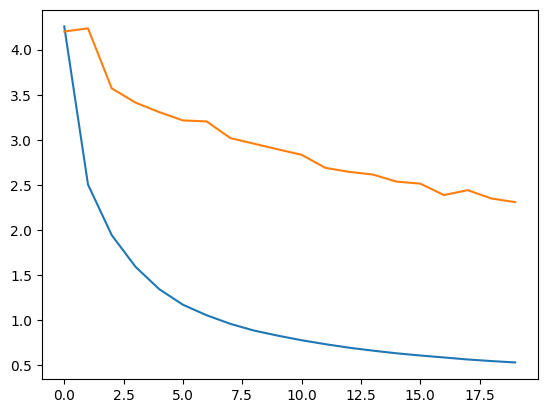

In [14]:
model_name = f"dpmerf_priv_embed{emb_dim}.pth"
if os.path.exists(f"models/{model_name}"):
    ae_gen.load_model(model_name)
else:
    model, history = ae_gen.train_model(train_ds_path=f"data/generated/normal_train_180_embed{emb_dim}_priv_merf.csv", val_ds_path="data/normal_val_180.csv")
    plt.plot(history["train"])
    plt.plot(history["val"])
    ae_gen.save_model(model_name)

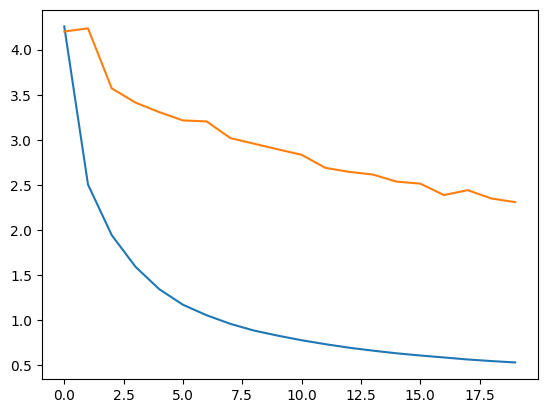

In [15]:
plt.plot(history["train"])
plt.plot(history["val"])
plt.title("Loss of AE on AE-MERF data")
plt.legend(["Training", "Validation"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [16]:
window_size=180
evaluator = Evaluator(test_normal_path=f"data/normal_test{window_size}.csv",
                        test_anomaly_path=f"data/anomalie_test{window_size}.csv", 
                        test_anomaly_label_path=f"data/anomalie_labels_{window_size}.csv",
                        model=ae_gen.model)

/home/user1-asd-arch/.local/share/virtualenvs/code-b8C0A6mP/lib/python3.7/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([180, 1])) that is different to the input size (torch.Size([1, 180, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


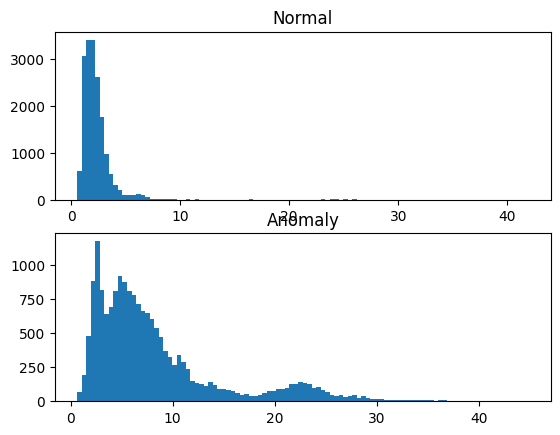

In [17]:
plt.figure()

plt.subplot(2,1,1)
plt.hist(evaluator.loss_normal, bins=100)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.title("Distribution of reconstruction error on normal heartbeats")

plt.subplot(2,1,2)
plt.hist(evaluator.loss_anomaly, bins=100)
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.title("Distribution of reconstruction error on anomalous heartbeats")
plt.tight_layout()

plt.show()

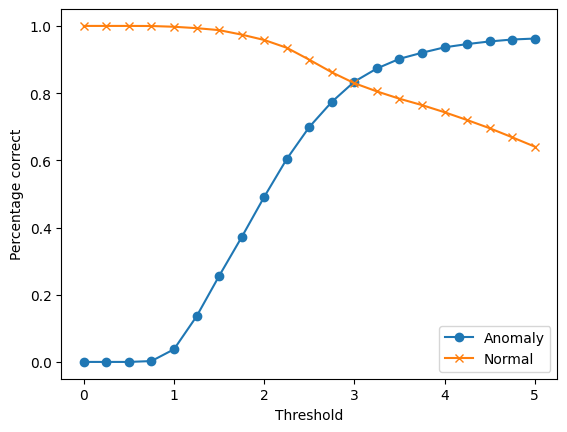

In [18]:
corr_normal, corr_anomaly = evaluator.find_threshold()
plt.plot(np.linspace(0,5,21), corr_normal, marker="o")
plt.plot(np.linspace(0,5,21), corr_anomaly, marker="x")
plt.xlabel("Threshold")
plt.ylabel("Percentage correct")
plt.legend(["Anomaly", "Normal"])
plt.title("Classification performance depending on error threshold")
plt.show()

In [19]:
predictions_normal, predictions_anomaly = evaluator.predict_class(3)


In [20]:
evaluator.evaluate(predictions_normal, predictions_anomaly)

TP: 14676
FN: 2918
FP: 3075
TN: 14965
Acc: 0.8318179266992198
Precision: 0.8267703227987155
Recall: 0.8341480050017052
F1: 0.8304427783279106
